# imports

In [1]:
import pandas as pd
from os import path
import numpy as np
from random import choice

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tqdm import tqdm

import seaborn as sns

# reading data

In [2]:
df = pd.read_csv(path.join('..','data','Data.csv'),usecols = ['Irr', 'Icc', 'Vcc', 'Tpm', 'Class'])

In [3]:
df.head()

,Irr,Icc,Vcc,Tpm,Class
0,10,0.0,234,20.1,0
1,10,0.0,234,20.1,0
2,10,0.1,234,20.0,0
3,10,0.1,234,20.0,0
4,10,0.0,234,20.0,0


# Data Analyse

/home/erik/Documentos/fuzzy/.env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


'maior concentração de irradiância nas faixas de 500 a 600'

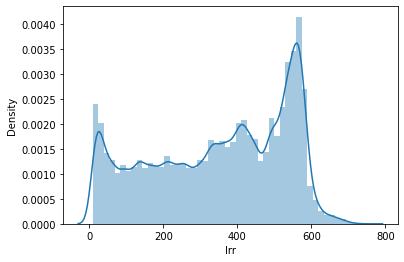

In [5]:
sns.distplot(df['Irr']) 
'''maior concentração de irradiância nas faixas de 500 a 600'''

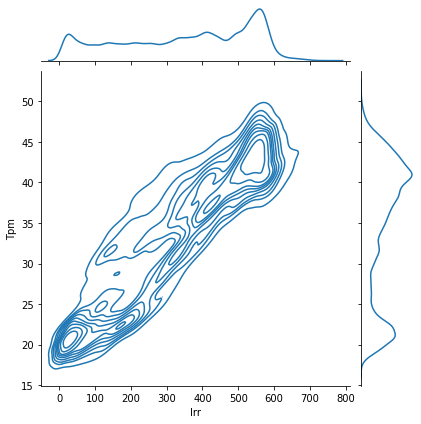

In [5]:
sns.jointplot(x='Irr', y='Tpm', data=df, kind='kde')

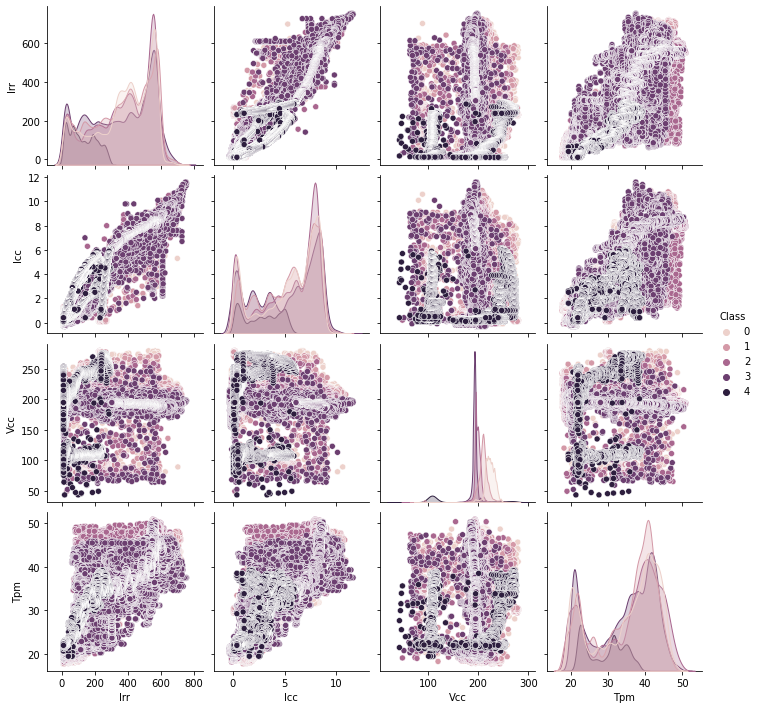

In [6]:
sns.pairplot(df, hue='Class')

<AxesSubplot:xlabel='Class', ylabel='Irr'>

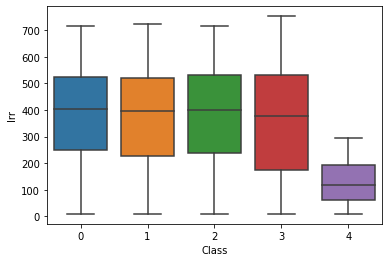

In [17]:
sns.boxplot(x='Class', y='Irr', data=df) #, hue='Class'

<AxesSubplot:xlabel='Class', ylabel='Irr'>

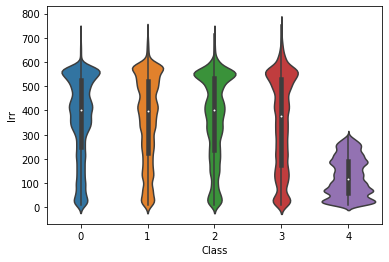

In [16]:
sns.violinplot(x='Class', y='Tpm', data=df) #, hue='Class'

In [9]:
corr_data = df.corr() #correlação entre os dados (1 alta correlação perfeita)

<AxesSubplot:>

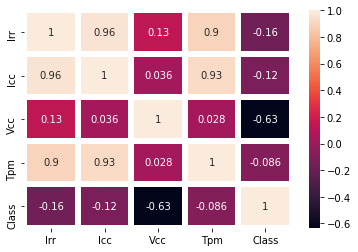

In [14]:
sns.heatmap(corr_data, annot=True, lw=5)

In [ ]:
'''Exists a high correlation betwenn Tpm and Icc/Irr. What mean that temperature
have a high influence in Icc and Irr.'''

# reading data to submit to SOM network

In [4]:
df = pd.read_csv(path.join('..','data','Data.csv'),usecols = ['Irr', 'Icc', 'Vcc', 'Tpm', 'Class'])
y = df.Class
df.drop(['Class'],axis=1, inplace=True)

# changing data scale (normalization)

In [5]:
# Instancia o MaxAbsScaler
p=MaxAbsScaler()
p.fit(df)
df_max_abs = p.transform(df)
df = pd.DataFrame(data=df_max_abs, columns=df.columns)

# data convertion int64 from int 32 and float64 from float 32

In [6]:
integer = df.select_dtypes('int64').columns
df[integer] = df[integer].apply(lambda x: x.astype('int32'))

#converte tipos obj em category(str)
floa = df.select_dtypes('float64').columns
df[floa] = df[floa].apply(lambda x: x.astype('float32'))

##### size of dataframe and memory usage

In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563897 entries, 0 to 563896
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Irr     563897 non-null  float32
 1   Icc     563897 non-null  float32
 2   Vcc     563897 non-null  float32
 3   Tpm     563897 non-null  float32
dtypes: float32(4)
memory usage: 8.6 MB


# split dataset in train and tetst

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state=42)

# Helper function for visualization

In [9]:
def visualize(h, color):
    #z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(h[:, 0], h[:, 1], s=5, c=color, cmap="Set2")
    #plt.plot(h[:, 0],h[:, 1],)
    plt.legend()
    plt.show()

# SOM network

In [10]:
class SOM:
    def __init__(self, row=1, column=1, input_len=1, learn_rate=0.5):
        
        self.row = row
        self.column = column
        self.input_len = input_len
        self.learn_rate = learn_rate
        self.weigth = np.random.rand((self.row * self.column), self.input_len)
        
    def initializing_weighs(self, X_train):
        
        self.weigth = []
        
        for i in range(self.row * self.column):
            self.weigth.append(choice(X_train))
            
        #print(np.array(self.weigth).shape)
        self.weigth = np.array(self.weigth)
    
    def d2_neighborhood_function(self, size=1):
        
        '''in this function, the neightborhood matrix is make. 
        It return one matrix with n row and m columns'''
        
        tam = self.row * self.column
        neuro = np.arange(tam)
        neuro = np.reshape(neuro, (self.row, self.column))
        neigh = size + 1     
        neighboors = []

        a = 0
        for d in range(self.row):
            b = d+neigh
            if d-neigh < 0: 
                a = 0
            else:
                a = abs(d-neigh)+1

            z = 0
            for y in range(self.column):
                t = y+neigh
                if y-neigh < 0: 
                    z = 0
                else:
                    z = abs(y-neigh)+1

                neighboors.append(neuro[a:b,z:t].reshape(-1))
                
        #print(neighboors)
                
        return neighboors
    
    def train(self, epoch=500, X_train=[], neigh=1):
        
        nt = self.learn_rate
        tmax = X_train.shape[0] * epoch
        
        vizi = self.d2_neighborhood_function(neigh)
        
        quantidade_escolhas = np.zeros(self.row * self.column)
        fi = 1
        
        lepra  = np.arange(epoch)
        
        for i in tqdm(lepra):
            xt = choice(X_train)
            ui = []

            for j, quant in zip(self.weigth, quantidade_escolhas):
                fi = (quant/(i+1)) ** 2
                ui.append(np.linalg.norm(j - xt) * fi)

            ui_winner = np.where(np.array(ui) == min(ui))
            quantidade_escolhas[ui_winner[0][0]] = quantidade_escolhas[ui_winner[0][0]] + 1

            for vizinhos in vizi[ui_winner[0][0]]:
                self.weigth[vizinhos] = self.weigth[vizinhos] + nt * (xt - self.weigth[vizinhos])

            if nt > 0.001:
                nt = nt * (1 - (i/epoch))
                
        return self.weigth

In [22]:
som_data = SOM(row=40, column=40, input_len=4, learn_rate=0.5)

In [23]:
som_data.initializing_weighs(X_train.values)

In [24]:
neuron = som_data.train(epoch=500, X_train=X_train.values, neigh=3)
neuron

100%|██████████| 500/500 [00:09<00:00, 54.55it/s]


array([[0.36730245, 0.3572192 , 0.7345023 , 0.6664508 ],
       [0.39744353, 0.4159869 , 0.73823386, 0.67130363],
       [0.47083032, 0.48895118, 0.72918326, 0.69899786],
       ...,
       [0.16600266, 0.03448276, 0.73571426, 0.4027505 ],
       [0.46613547, 0.47413793, 0.7392857 , 0.81925344],
       [0.7184595 , 0.67241377, 0.73214287, 0.82711196]], dtype=float32)

# KNN

In [25]:
def knn(X_train, y_train, X_test):

    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)

    KNeighborsClassifier(...)

    return neigh.predict(X_test)

In [26]:
#knn to define the output to neurons given to som_data
y_som = knn(X_train, y_train, neuron)

In [27]:
#knn to define the output to X_test
y_som_test = knn(neuron, y_som, X_test)

In [28]:
def pair_visualize(h1, h2, color1, color2):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    fig.suptitle('')
    
    ax1.set_title('y_som_test')
    
    ax2.set_title('y_real_test')
    colors=np.unique(color1)

    scatter2 = ax2.scatter(h2[:, 0], h2[:, 1], s=5, c=color2, cmap="Set2")
    scatter1 = ax1.scatter(h1[:, 0], h1[:, 1], s=5, c=color1, cmap="Set2")
    
    legend1 = ax1.legend(*scatter1.legend_elements(),loc="upper left", title="Classes")
    ax1.add_artist(legend1)
    
    #plt.legend(colors, ['0', '1', '2', '3', '4'])
    ax1.legend()
    ax1.grid(True)
    ax2.legend()
    ax2.grid(True)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


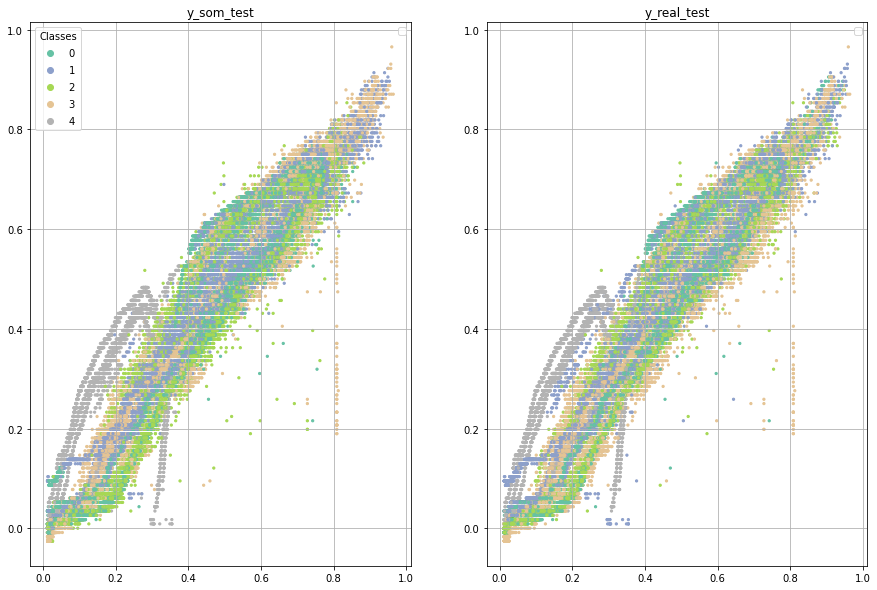

In [29]:
pair_visualize(h1=X_test.values,h2=X_test.values, color1=y_som_test, color2=y_test)

In [30]:
#metrics to model defined in som_data
print(classification_report(y_test, y_som_test))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     26271
           1       0.79      0.81      0.80     27921
           2       0.70      0.75      0.73     26782
           3       0.82      0.73      0.77     25918
           4       0.92      0.82      0.87      5888

    accuracy                           0.80    112780
   macro avg       0.82      0.81      0.81    112780
weighted avg       0.81      0.80      0.80    112780



In [ ]:
'''To 40x40 neuros, the SOM network Rated the X_test datas with 80% of f1-score.'''